In [4]:
from pathlib import Path
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
filter = [ "pluginAssetId", "assetId","interactionName" ]
keys = ["3750390182735137211", "5984175597303660107", "EXECUTE_PAGINATED_REPORT"]
config_id = "fciPluginAppInteractions"

# the below value filling should be closer to when the incident happens. We fetch 11 days of data. Train on first 10 days of data and the 11th and 12th day where incident happened we try to simulate inference and see scores.

from fakeredis import FakeStrictRedis, FakeServer
from numalogic.udfs import PipelineConf
import os
from omegaconf import OmegaConf

plt.rcParams["figure.figsize"] = (20,3)
conf_1 = OmegaConf.load(os.path.join(Path(os.getcwd()).parent.absolute(), 'experiment_config.yaml'))
schema = OmegaConf.structured(PipelineConf)
conf = OmegaConf.merge(schema, conf_1)
pl_conf = PipelineConf(**OmegaConf.merge(schema, conf_1))
input_features = ['failed', 'degraded']
REDIS_CLIENT = FakeStrictRedis(server=FakeServer())

import logging
logging.basicConfig(level = logging.INFO)
import pandas as pd

from helper import data_fetch, _construct_clf, get_feature_arr, ModifiedDruidTrainerUDF

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
file_name = 'e3e5f0b687600a109055c998dabb35d7.csv.csv'
data = pd.read_csv(file_name)
print("************************")
print(data['pluginassetid'].value_counts())
print("************************")
print(data['assetid'].value_counts())
print("************************")
print(data['interactionname'].value_counts())

************************
pluginassetid
3750390182735137211    6394767
Name: count, dtype: int64
************************
assetid
5984175597303660107    6392303
868086420502860411        1187
3606274994100084089       1038
362557362191815079         175
1227248490647011465         64
Name: count, dtype: int64
************************
interactionname
EXECUTE_PAGINATED_REPORT               2714194
PAGINATE_REPORT                        2559837
DRILLDOWN_REPORT_FETCH                  574156
EXPORT_REPORT_EXCEL                     224646
EXPORT_REPORT_PDF                       152588
UPDATE_REPORT                            98608
CHART_RENDER                             22341
templado-load-chart                      21914
EXPORT_REPORT_CSV                        18537
EMAIL_REPORT_TABLE                        2949
REPORT_SAVE                               1712
REPORT_READ                               1381
REPORT_SCHEMA_FETCH                       1372
REPORT_OPERATION_SCHEMA_FETCH         

In [6]:
_out = data_fetch(filter= filter, keys = keys, file_name = file_name)
_out["timestamp"]  = pd.to_datetime(_out['timestamp'], unit='ms').dt.strftime('%Y-%m-%d %H:%M')
_out.set_index('timestamp', inplace = True)
train = _out.iloc[:-2*24*60,:]
test = _out.iloc[-24*60*2:,:]
train.to_csv(str(file_name)+'-train.csv', index= None)
test.to_csv(str(file_name)+'-test.csv', index= None)

<Axes: xlabel='timestamp'>

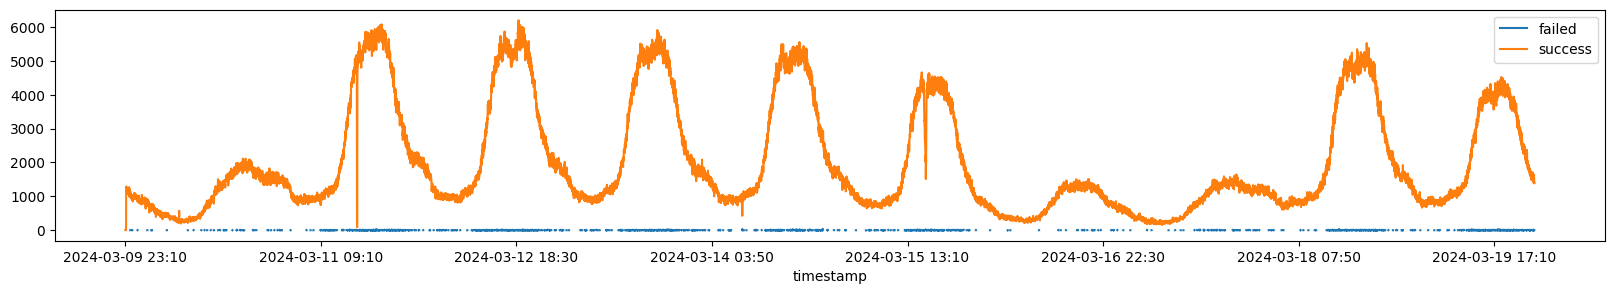

In [7]:
train.plot()

<Axes: xlabel='timestamp'>

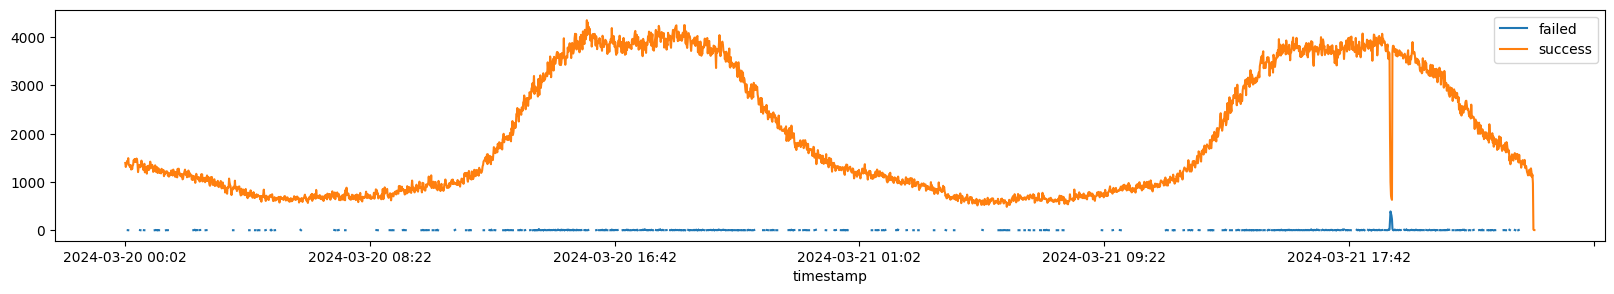

In [8]:
test.plot()

In [33]:
from numalogic.udfs import PreprocessUDF, PostprocessUDF, InferenceUDF

preproc_udf= PreprocessUDF(REDIS_CLIENT, pl_conf=pl_conf)
_stream_conf = preproc_udf.get_stream_conf(config_id)
_conf = _stream_conf.ml_pipelines["metrics"]
inference_udf= InferenceUDF(REDIS_CLIENT, pl_conf=pl_conf)
postproc_udf= PostprocessUDF(REDIS_CLIENT, pl_conf=pl_conf)
trainer_udf = ModifiedDruidTrainerUDF(REDIS_CLIENT, pl_conf=pl_conf, file =file_name)

# TRAINER

In [34]:
from torchinfo import summary
from numalogic.config import ModelFactory, ThresholdFactory

preproc_clf = _construct_clf(_conf.numalogic_conf.preprocess)
trainer_transform = _construct_clf(_conf.numalogic_conf.trainer.transforms)
model = ModelFactory().get_instance(_conf.numalogic_conf.model)
thresh_clf = ThresholdFactory().get_instance(_conf.numalogic_conf.threshold)
print(summary(model))   
data,_,_= get_feature_arr(train, metrics=input_features)
artifact, train_reconerr = trainer_udf.compute(model = model,input_=data ,preproc_clf=preproc_clf, trainer_transform=trainer_transform,threshold_clf=thresh_clf, numalogic_cfg=_conf.numalogic_conf)

Layer (type:depth-idx)                   Param #
VanillaAE                                --
├─_Encoder: 1-1                          --
│    └─Sequential: 2-1                   --
│    │    └─Linear: 3-1                  336
│    │    └─BatchNorm1d: 3-2             2
│    │    └─Tanh: 3-3                    --
│    │    └─Dropout: 3-4                 --
│    │    └─Linear: 3-5                  136
│    │    └─BatchNorm1d: 3-6             2
│    │    └─ReLU: 3-7                    --
├─_Decoder: 1-2                          --
│    └─Sequential: 2-2                   --
│    │    └─Linear: 3-8                  144
│    │    └─BatchNorm1d: 3-9             2
│    │    └─Tanh: 3-10                   --
│    │    └─Dropout: 3-11                --
│    │    └─Linear: 3-12                 340
Total params: 962
Trainable params: 962
Non-trainable params: 0


/var/folders/jb/4hljhp7n15n02dmg5h125lnm0000gp/T/ipykernel_90227/2778923605.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df[col] = fill_value
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | encoder | _Encoder | 476   
1 | decoder | _Decoder | 486   
-------------------------------------
962       Trainable params
0         Non-trainable params
962  

tensor([[4.1866e-02],
        [7.5267e-03],
        [4.1866e-02],
        ...,
        [2.8352e-04],
        [1.8445e-01],
        [5.0175e-05]])


<Axes: >

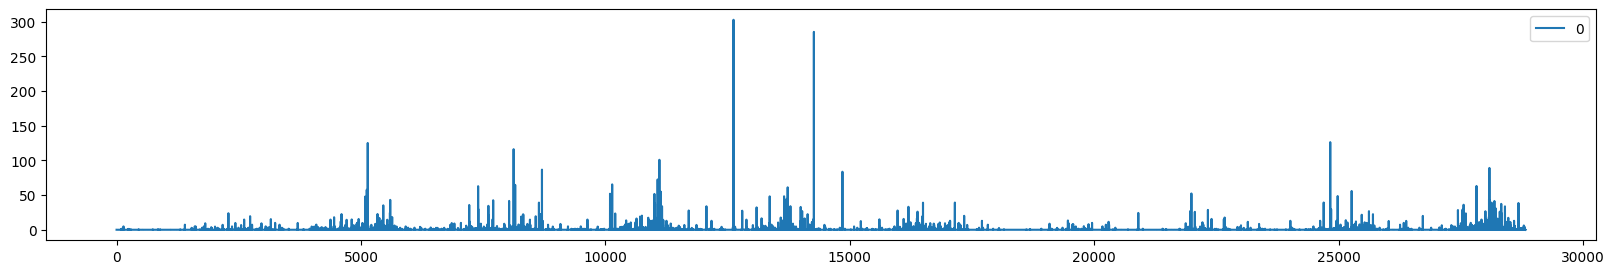

In [35]:
pd.DataFrame(train_reconerr).plot()

# INFERENCE PL

In [37]:
from numalogic.tools.data import StreamingDataset

test_data ,_,_= get_feature_arr(test, metrics=input_features)
ds = StreamingDataset(test_data, seq_len=pl_conf.stream_confs[config_id].window_size)

/var/folders/jb/4hljhp7n15n02dmg5h125lnm0000gp/T/ipykernel_90227/2778923605.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df[col] = fill_value


In [38]:
artifact

{'preproc_clf': KeyedArtifact(dkeys=['StandardScaler', 'FlattenVector'], artifact=Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('flattenvector',
                  <numalogic.transforms._stateless.FlattenVector object at 0x2700063d0>)]), stateful=True),
 'inference': KeyedArtifact(dkeys=['VanillaAE'], artifact=VanillaAE(
   (encoder): _Encoder(
     (encoder): Sequential(
       (0): Linear(in_features=20, out_features=16, bias=True)
       (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): Tanh()
       (3): Dropout(p=0.25, inplace=False)
       (4): Linear(in_features=16, out_features=8, bias=True)
       (5): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (6): ReLU()
     )
   )
   (decoder): _Decoder(
     (decoder): Sequential(
       (0): Linear(in_features=8, out_features=16, bias=True)
       (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [39]:
from numalogic.config import PostprocessFactory, ScoreConf

preproc_clf = artifact['preproc_clf'].artifact
model = artifact['inference'].artifact
thresh_clf = artifact['threshold_clf'].artifact
postproc_tx = PostprocessFactory().get_instance(_conf.numalogic_conf.postprocess)
score = []
infer_score = []
for arr in ds:
    preproc_data = preproc_clf.transform(arr)
    infer_data  = inference_udf.compute(model = model, input_ =preproc_data)
    infer_score.append(infer_data.mean())
    postproc_data = postproc_udf.compute(model = thresh_clf, input_ =infer_data, postproc_tx=postproc_tx, score_conf=ScoreConf()) 
    score.append(postproc_data.mean())

# Final Anomaly Score for the window

<Axes: xlabel='timestamp'>

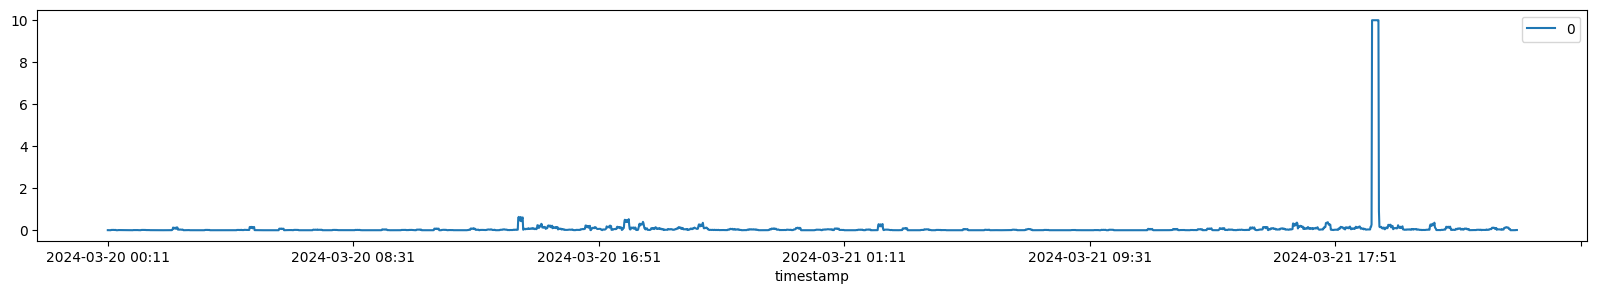

In [40]:
import pandas as pd

pd.DataFrame(score, index=test[9:].index).plot()

# Failed metrics during the incident time

<Axes: xlabel='timestamp'>

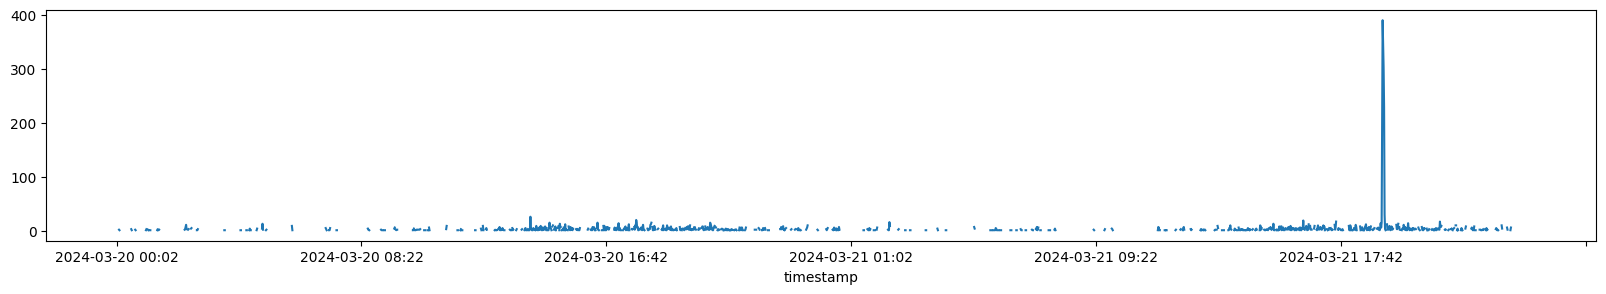

In [41]:
test['failed'].plot()

# Degraded metrics during the incident time

<Axes: xlabel='timestamp'>

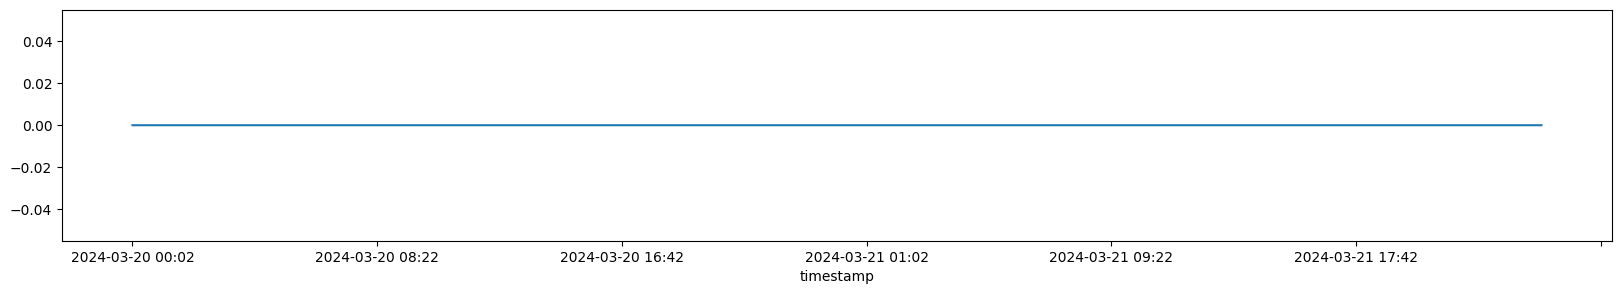

In [42]:
test['degraded'].plot()